In [1]:
import pandas as pd
import numpy as np
import pathlib
from scipy import constants
from pprint import pprint
import matplotlib.pyplot as plt
if True:
    import sys
    sys.path.append("/home/salmon/workspace/fytok/python")
    sys.path.append("/home/salmon/workspace/SpDB/python")

    from fytok.load_profiles import (load_core_profiles, load_core_source,
                                     load_core_transport, load_equilibrium)
    from fytok.modules.transport.Equilibrium import Equilibrium
    from fytok.numlib.smooth import rms_residual
    from spdm.data import File, Function, Query
    from spdm.logger import logger


###########################


In [2]:
eqdsk_file = File(
    "/home/salmon/workspace/data/15MA inductive - burn/Standard domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16HR.txt", format="geqdsk").read()
desc = load_equilibrium(eqdsk_file,
                        coordinate_system={
                            "psi_norm": np.linspace(0.0,  0.995, 32),
                            "theta": 64},
                        code={"name": "dummy"},
                        boundary={"psi_norm": 0.995}
                        )
eq = Equilibrium(desc)
psi_norm = np.linspace(0.0, 0.995, 32)


2022-09-16 12:14:54,758 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/sp_export.py:101:sp_find_module_by_name: Load module spdm.plugins.data.file.PluginGEQdsk
2022-09-16 12:14:54,759 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/data/File.py:65:__init__: Open GEQdskFile: /home/salmon/workspace/data/15MA inductive - burn/Standard domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16HR.txt mode='r'
2022-09-16 12:14:54,763 DEBUG [spd] /home/salmon/workspace/fytok/python/spdm/plugins/data/file/PluginGEQdsk.py:286:__init__: Open File /home/salmon/workspace/data/15MA inductive - burn/Standard domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16HR.txt mode=r
2022-09-16 12:14:54,894 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/sp_export.py:101:sp_find_module_by_name: Load module fymodules.transport.equilibrium.dummy


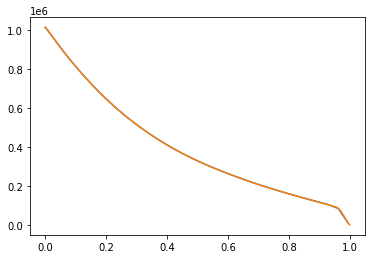

In [3]:
plt.plot(psi_norm, eq.profiles_1d.pressure(psi_norm))
plt.plot(eq.profiles_1d._predefined_psi_norm, eq.profiles_1d.pressure())


/fuyun/software/SciPy-bundle/2020.11-foss-2020b/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


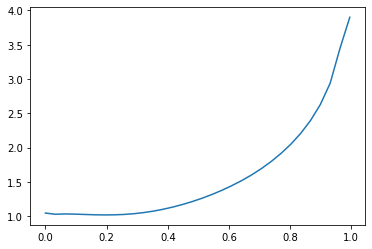

In [4]:
plt.plot(psi_norm, eq.profiles_1d.q())